# Neural Network 

## 1. Imports

In [58]:
import HelperFunctions as hf
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
import torch
import torch.optim as optim
from torch import nn
import torch.nn.functional as F

## 2. Fetching and preparing data

In [59]:
#Load in the raw data
calendar_df = hf.load_calendar_data()
prices_df = hf.load_sell_price_data()
sales_df = hf.load_sales_train_validation_data()

In [60]:
#Clean the raw data
df = hf.rawToClean(sales_df, calendar_df, prices_df, days=1200, items=100, dropNAPrices=True)

In [61]:
df = hf.rollingMeanDemandFeature(df, windowSize=7, shift=1) #Mean of previous week
df = hf.rollingMeanDemandFeature(df, windowSize=28, shift=1) #Mean of previous 28 days

In [62]:
df = hf.rollingMeanWeekday(df, weeks = 3, shift = 1) #mean of previous 3 weeks (for that particular weekday)

In [63]:
df = hf.lagFeature(df, var='sold', lag=1) #Amount sold day before
df = hf.lagFeature(df, var='sold', lag=7) #Amount sold a week before
df = hf.lagFeature(df, var='sold', lag=28) #Amount sold 28 days before

In [64]:
df.dropna(inplace=True) #Drop rows with NAs (as result of lagged features)

In [65]:
df.drop(['id'], axis=1, inplace=True) #Drop the id column

In [66]:
#Standardise features
cols_to_norm = ['d','wday','month','year','sell_price','rolling_mean_7_1','rolling_mean_28_1','sold_lag_1',
                'sold_lag_7','sold_lag_28']

df[cols_to_norm] = MinMaxScaler().fit_transform(df[cols_to_norm])

In [67]:
df.shape

(78827, 47)

## 3. Setting up loaders

In [68]:
#Isolate features and target variable
y = df.sold.values
X_df = df.drop(['sold'], axis=1)
X = X_df.values



In [69]:
X = X.astype(float)
y = y.astype(float)

In [70]:
X, y = torch.FloatTensor(X), torch.FloatTensor(y)

In [71]:
#Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [72]:
X_train.shape, y_train.shape

(torch.Size([63061, 46]), torch.Size([63061]))

In [73]:
# create data loaders

from torch.utils import data

traindataset = data.TensorDataset(X_train, y_train) # create your datset
trainloader = data.DataLoader(traindataset, batch_size=1024, shuffle=True) # create your dataloader


testdataset = data.TensorDataset(X_test,y_test) # create your datset
testloader = data.DataLoader(testdataset, batch_size=1024, shuffle=True) # create your dataloader



## 4. Building neural net

In [83]:
# define baseline model
class BaselineModel(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(BaselineModel, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size) 
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, hidden_size)
        self.fc4 = nn.Linear(hidden_size, hidden_size)
        self.fc5 = nn.Linear(hidden_size, 1)  
    
    def forward(self, x):
        out = self.fc1(x)
        out = F.relu(out)
        out = self.fc2(out)
        out = F.relu(out)
        out = self.fc3(out)
        out = F.relu(out)
        out = self.fc4(out)
        out = F.relu(out)
        out = self.fc5(out)
        
        return out

In [96]:
# build the model 
model = BaselineModel(46, 256)

# define the loss function and the optimiser
loss_function = nn.MSELoss()
optimiser = optim.Adam(model.parameters())

# the epoch loop
for epoch in range(10):
    running_loss = 0.0

    for data in trainloader:
        # get the inputs
        inputs, labels = data

        # zero the parameter gradients
        optimiser.zero_grad()

        # forward + loss + backward + optimise (update weights)
        outputs = model(inputs)
        outputs = outputs.flatten()
        loss = loss_function(outputs, labels)
        loss.backward()
        optimiser.step()

        # keep track of the loss this epoch
        running_loss += loss.item()

    print("Epoch %d, loss %4.2f" % (epoch, running_loss))
print('**** Finished Training ****')

Epoch 0, loss 480.18
Epoch 1, loss 381.59
Epoch 2, loss 363.65
Epoch 3, loss 347.52
Epoch 4, loss 309.20
Epoch 5, loss 297.76
Epoch 6, loss 295.99
Epoch 7, loss 301.28
Epoch 8, loss 287.39
Epoch 9, loss 282.61
**** Finished Training ****


In [97]:
from sklearn.metrics import mean_squared_error

[[0.21318802]
 [0.1960243 ]
 [1.3644631 ]
 ...
 [0.53673023]
 [0.54211897]
 [0.31119722]]


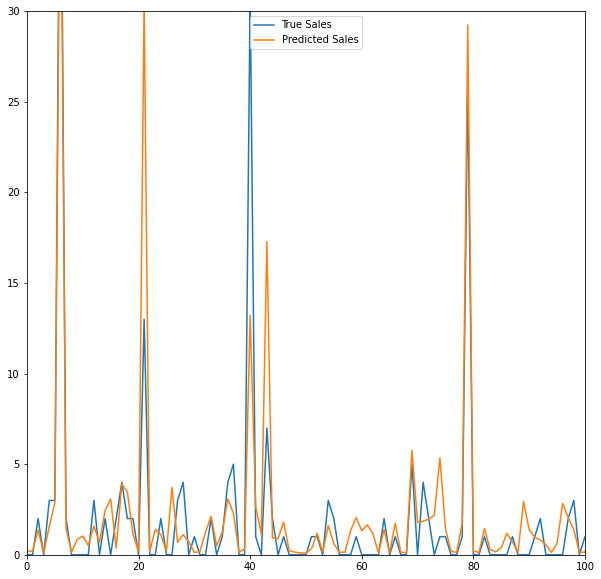

In [100]:
model.eval()
plt.figure(figsize = (10,10))
for index, i in enumerate(trainloader):
    if index < 1:
        inputs, labels = i
          
        outputs = model(inputs)
        outputs = outputs.detach().numpy()
        plt.plot([i for i in range(len(labels))], labels, label = "True Sales")
        print(outputs)
        plt.plot(outputs, label = "Predicted Sales")
        plt.legend()
        plt.ylim(0, 30)
        plt.xlim(0, 100)
        #print(inputs, labels)
    else:
        break

[[0.16597874]
 [0.14529265]
 [0.5329244 ]
 ...
 [1.8252137 ]
 [0.37956595]
 [0.0977665 ]]


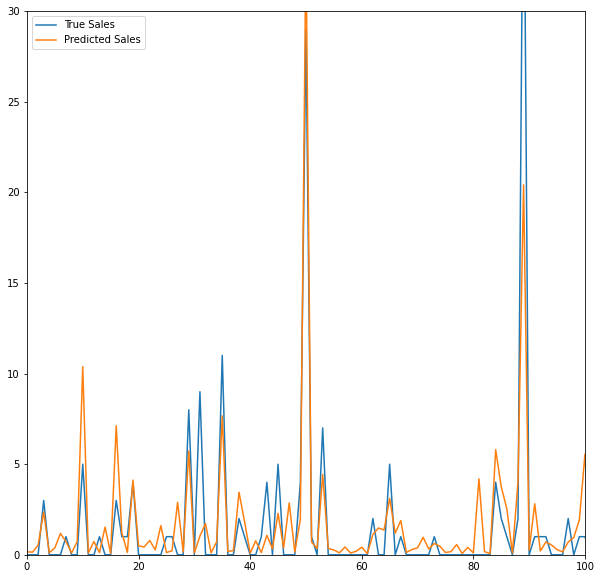

In [101]:
model.eval()
plt.figure(figsize = (10,10))
for index, i in enumerate(testloader):
    if index < 1:
        inputs, labels = i
          
        outputs = model(inputs)
        outputs = outputs.detach().numpy()
        plt.plot([i for i in range(len(labels))], labels, label = "True Sales")
        print(outputs)
        plt.plot(outputs, label = "Predicted Sales")
        plt.legend()
        plt.ylim(0, 30)
        plt.xlim(0, 100)
        #print(inputs, labels)
    else:
        break

In [106]:
model.eval()

mse = 0

for data in trainloader:
    inputs, labels = data
    
    outputs = model(inputs)
    
    outputs = outputs.detach().numpy()
    mse += mean_squared_error(labels, outputs)
print("Train: ", mse/len(X_train))

Train:  0.004492759095887298


In [105]:
model.eval()

mse = 0

for data in testloader:
    inputs, labels = data
    
    outputs = model(inputs)
    
    outputs = outputs.detach().numpy()
    mse += mean_squared_error(labels, outputs)
print("Test: ", mse/len(X_test))

Test:  0.004755531911330977
